In [1]:
# Import necessary libraries
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Note: steps 1 and 2 are done on a larger scale using Make_data.py

# 3. after running Make_data.py in parallel

In [ ]:
## IWV special process
time_data = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research2/3hrly_merra2_hemisphere/LWTNET/LWTNET_2002*')
time_data = time_data.time

data = xr.open_mfdataset('/rc_scratch/reba1583/variable_yr_files_2/IWV_2002')
data = data.assign_coords({'time': time_data})

data = data.load()

period = 1460
data = data.interp(lat = np.arange(-90,1,1), lon = np.arange(-180,181,1), time = pd.date_range("2002-01-01T00:00:00.000000000", periods= period, freq="6H"))

data.to_netcdf('/rc_scratch/reba1583/variable_yr_files_3/IWV_2002')

In [ ]:
# combine years of data
variable = 'LWTNET'
test = xr.open_mfdataset('/rc_scratch/reba1583/variable_yr_files_3/'+str(variable)+'*')
test = test.load()
test.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr/LWTNET.nc')

# 3. Compile and format data for training (a, b, c)

## a. feature data

In [4]:
fp = '/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr/'

H = xr.open_mfdataset(fp+'H500.nc')
IWV = xr.open_mfdataset(fp +'IWV.nc')
EFLUX = xr.open_mfdataset(fp +'EFLUX.nc')
LWTNET = xr.open_mfdataset(fp +'LWTNET.nc')
SF = xr.open_mfdataset(fp +'sf200.nc')
SLP = xr.open_mfdataset(fp +'SLP.nc')
T = xr.open_mfdataset(fp +'T950.nc')
U = xr.open_mfdataset(fp +'U950.nc')
V = xr.open_mfdataset(fp +'V950.nc')


variable_times = T.time
H = H.squeeze()
H = np.array(H.H)


In [5]:
data = np.stack([H, np.array(IWV.IWV), np.array(EFLUX.EFLUX), np.array(LWTNET.LWTNET),
                 np.array(SF.sf), np.array(SLP.SLP), np.array(T.T), np.array(U.U), np.array(V.V)])

In [6]:
del H
del V 
del U
del T
del IWV
del EFLUX
del SF
del SLP
del LWTNET


In [8]:
data

array([[[[ 5.05785107e+03,  5.05785107e+03,  5.05785107e+03, ...,
           5.05785107e+03,  5.05785107e+03,             nan],
         [ 5.05328857e+03,  5.05328857e+03,  5.05328857e+03, ...,
           5.05322607e+03,  5.05322607e+03,             nan],
         [ 5.04616357e+03,  5.04616357e+03,  5.04603857e+03, ...,
           5.04628857e+03,  5.04628857e+03,             nan],
         ...,
         [ 5.83153857e+03,  5.83248877e+03,  5.83333838e+03, ...,
           5.83078857e+03,  5.83073877e+03,             nan],
         [ 5.83303857e+03,  5.83373877e+03,  5.83438867e+03, ...,
           5.83228857e+03,  5.83238867e+03,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 5.05417725e+03,  5.05417725e+03,  5.05417725e+03, ...,
           5.05417725e+03,  5.05417725e+03,             nan],
         [ 5.04867725e+03,  5.04867725e+03,  5.04867725e+03, ...,
           5.04861475e

## b. 1D labeling - Is there an AR making landfall?

In [7]:
# category 1d label data: is there a landfalling AR or no

centers = pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/ML_test_artimes_centers.csv')
centers = centers[pd.to_datetime(centers.AR_time)<pd.to_datetime('2003-01-01')]

ar_times = pd.to_datetime(np.array(centers.AR_time))

times_resampled = []
for i in range(len(ar_times)):
    if ar_times[i].hour in [0,6,12,18]:
        times_resampled.append(ar_times[i])
    else:
        times_resampled.append(ar_times[i] - pd.Timedelta(hours = 3))

ar_times_6hrly = pd.to_datetime(np.unique(times_resampled))
    
times = pd.DataFrame({'time':pd.to_datetime(np.array(variable_times))}).set_index('time')

times['AR_flag'] = np.zeros(len(times))
times.AR_flag[times.index.isin(ar_times_6hrly)] = 1

ar_flag = np.array(times.AR_flag)


## c. 2d labeling, AR masks

In [8]:
# 2d label data: AR outlines
ar_catalog = xr.open_mfdataset(['/projects/reba1583/Research2/data/AR_catalogue/2000.nc', '/projects/reba1583/Research2/data/AR_catalogue/2001.nc', '/projects/reba1583/Research2/data/AR_catalogue/2002.nc']).sel(lat =slice(-90,0))
ar_catalog = ar_catalog.interp(lon = np.arange(-180,181,1), lat = np.arange(-90,1,1), time = pd.date_range("2000-01-01T00:00:00.000000000", periods= 4384, freq="6H"))

#this part is a little suspect- consider something different than the interpolation method above
ar_catalog = np.array(ar_catalog.ar_binary_tag)
ar_catalog[np.isnan(ar_catalog)] = 0
ar_catalog[ar_catalog>0] = 1
ar_catalog[ar_catalog<0] = 0

In [9]:
var_data = dict(
    features = (['n_channel', 'time', 'lat', 'lon' ], data),
    label_1d_AR = (['time'], ar_flag),
    label_2d_AR = (['time', 'lat', 'lon'], ar_catalog)
)

coords = dict(
    id = (['time'], ar_flag),
    n_channel = (['n_channel'], np.array(['H', 'IWV', 'EFLUX', 'LWTNET', 'SF', 'SLP', 'T', 'U', 'V'])),
    time = (['time'], pd.to_datetime(np.array(variable_times)))
    
)

ds = xr.Dataset(
    data_vars = var_data, 
    coords = coords
)

In [13]:

ds


<xarray.Dataset>
Dimensions:      (n_channel: 9, time: 4384, lat: 91, lon: 361)
Coordinates:
    id           (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * n_channel    (n_channel) <U6 'H' 'IWV' 'EFLUX' 'LWTNET' ... 'T' 'U' 'V'
  * time         (time) datetime64[ns] 2000-01-01 ... 2002-12-31T18:00:00
Dimensions without coordinates: lat, lon
Data variables:
    features     (n_channel, time, lat, lon) float64 5.058e+03 5.058e+03 ... nan
    label_1d_AR  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    label_2d_AR  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [12]:
ds.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr/data.nc')

# 4. Plot one timestep of input data and AR Catalog

In [8]:
#define function 
def show_sample(ds):
    num_channels = len(ds_sample.n_channel)
    #define figure with 1 row and 5 columns. 
    fig,axes = plt.subplots(num_channels+1,1,figsize=(10, num_channels*5))
    #set the background to white, for some reason its transparent
    fig.set_facecolor('w')
    #choose some colormaps for drawing
    cmaps = ['Blues','turbo','Spectral_r','Greys_r', 'Blues','turbo','Spectral_r','Greys_r', 'Blues','turbo','Spectral_r','Greys_r']
    #loop over features (inputs)
    for i,ax in enumerate(axes[0:num_channels]):
        #plot images
        ax.imshow(ds.isel(n_channel = i).features,cmap=cmaps[i])
        ax.axis('off')
        ax.set_title(ds.n_channel[i].values)

    #plot labels (output) which is GLM 
    ax = axes[num_channels]
    ax.imshow(ds.label_2d_AR[:,:],cmap='magma')
    ax.axis('off')
    ax.set_title('glm')

#     fig.suptitle('class label: {}, n flashes: {}'.format(ds.label_1d_class.values,ds.label_1d_reg.values),y=0.75)

    return ds.id.values

array(0.)

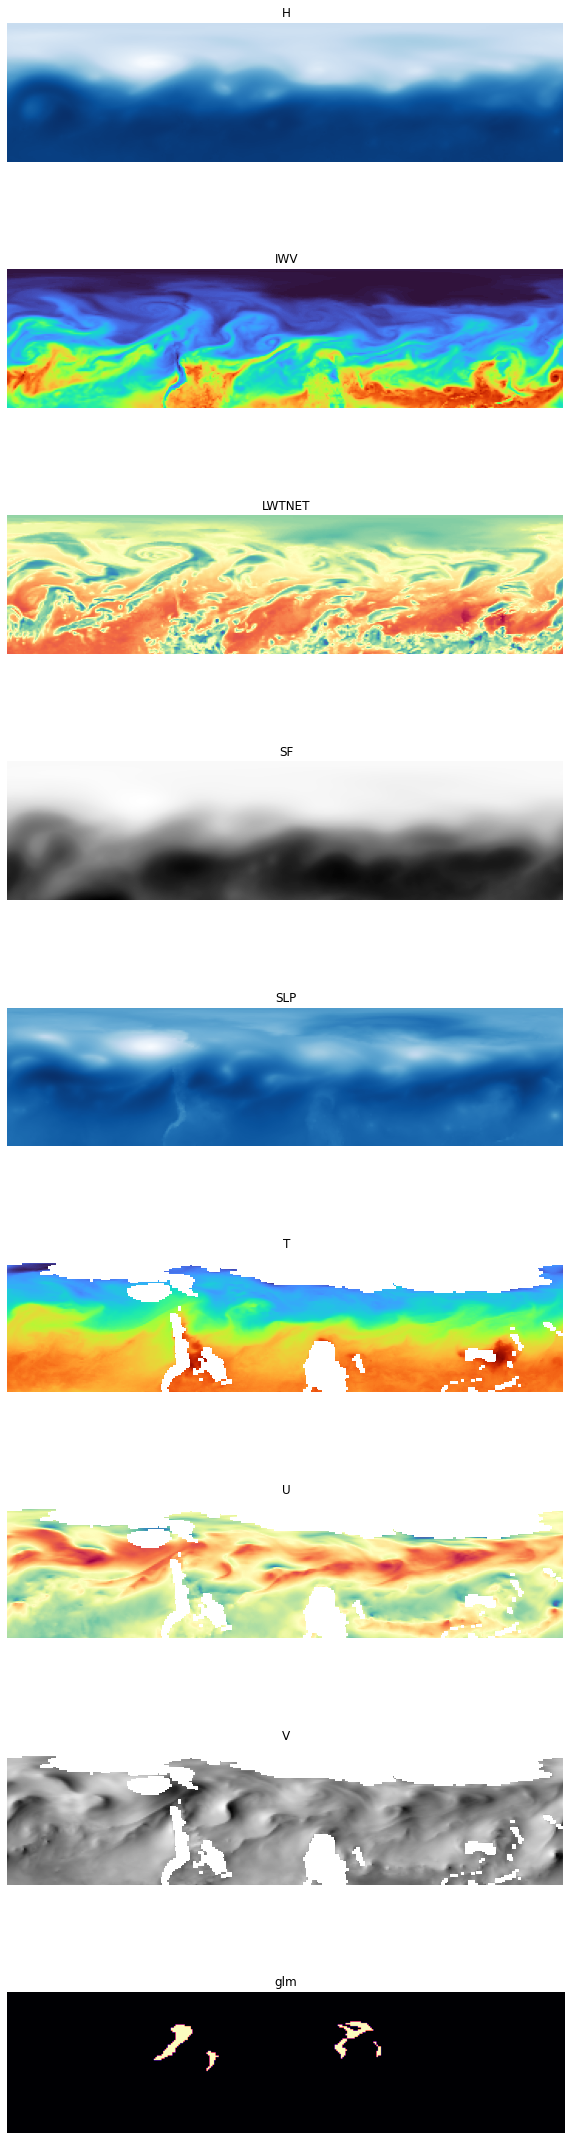

In [9]:
ds_sample = ds.isel(time = 96)
show_sample(ds_sample)

# 5. Split Data into train and test

In [6]:
ds = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr/data.nc')

In [7]:
index = np.arange(len(ds.time))
split1, split2 = int(.8*len(index)), int(.9*len(index))


np.random.shuffle(index)
index_train, index_validate, index_test = index[:split1], index[split1:split2], index[split2:]
index_train.sort()
index_validate.sort()
index_test.sort()

In [8]:
ds_train = ds.isel(time = index_train)
ds_test = ds.isel(time = index_test)
ds_validate = ds.isel(time = index_validate)

In [10]:
ds_test.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr/ds_test.nc')

In [11]:
ds_train.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr/ds_train.nc')

In [12]:
ds_validate.to_netcdf('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/3yr/ds_validate.nc')